In [30]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x) 
import numpy as np
import seaborn as sns
sns.set_palette("Set2")
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import warnings
warnings.simplefilter('ignore')

In [5]:
# read all data, contatinate to 1 df, note data format different from year to year

extension = 'csv'
all_filenames = list(Path('../data/data_used').glob('*.{extension}'.format(extension=extension)))
df = pd.concat([pd.read_csv(f, dtype={'start_station_id': str,'end_station_id': str}) for f in all_filenames ])
df.shape

(3489748, 13)

In [6]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,BD0A6FF6FFF9B921,electric_bike,2020-11-01 13:36:00,2020-11-01 13:45:40,Dearborn St & Erie St,110,St. Clair St & Erie St,211,41.89,-87.63,41.89,-87.62,casual
1,96A7A7A4BDE4F82D,electric_bike,2020-11-01 10:03:26,2020-11-01 10:14:45,Franklin St & Illinois St,672,Noble St & Milwaukee Ave,29,41.89,-87.64,41.90,-87.66,casual
2,C61526D06582BDC5,electric_bike,2020-11-01 00:34:05,2020-11-01 01:03:06,Lake Shore Dr & Monroe St,76,Federal St & Polk St,41,41.88,-87.62,41.87,-87.63,casual
3,E533E89C32080B9E,electric_bike,2020-11-01 00:45:16,2020-11-01 00:54:31,Leavitt St & Chicago Ave,659,Stave St & Armitage Ave,185,41.90,-87.68,41.92,-87.69,casual
4,1C9F4EF18C168C60,electric_bike,2020-11-01 15:43:25,2020-11-01 16:16:52,Buckingham Fountain,2,Buckingham Fountain,2,41.88,-87.62,41.88,-87.62,casual


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3489748 entries, 0 to 388652
Data columns (total 13 columns):
ride_id               object
rideable_type         object
started_at            object
ended_at              object
start_station_name    object
start_station_id      object
end_station_name      object
end_station_id        object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual         object
dtypes: float64(4), object(9)
memory usage: 372.7+ MB


In [8]:
df.describe()

,start_lat,start_lng,end_lat,end_lng
count,3489748.00,3489748.00,3485010.00,3485010.00
mean,41.90,-87.64,41.90,-87.65
std,0.04,0.03,0.04,0.03
min,41.64,-87.87,41.54,-88.07
25%,41.88,-87.66,41.88,-87.66
50%,41.90,-87.64,41.90,-87.64
75%,41.93,-87.63,41.93,-87.63
max,42.08,-87.52,42.16,-87.44


In [14]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

In [9]:
# cleaning, drop missing, correct data type
df = df.dropna(axis=0)
df.shape

(3294691, 13)

In [11]:
# create new metrics time_length, distance, 
df[['ended_at', 'started_at']] = df[['ended_at', 'started_at']].apply(pd.to_datetime)
df['time_length'] = df['ended_at'] - df['started_at']
df['time_length'] = df['time_length'].dt.total_seconds()

In [12]:
# create new metrics, speed
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371  # earch radius
    # convert lat, lng to radians
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2-lat1)
    delta_lambda = np.radians(lon2-lon1)
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    res = r * (2*np.arctan2(np.sqrt(a), np.sqrt(1-a)))
    return np.round(res, 2)

df['dist'] = haversine_distance(df.start_lat, df.start_lng, df.end_lat, df.end_lng)
# speed as meter/second
df['speed'] = df['dist']*1000 / df['time_length']

In [35]:
# output for Tableau
df.to_csv('../results/divvy-tripdata-2020_2021.csv', index=False, header=True, float_format='%.2f')

In [13]:
### data integrity, outliers
df.time_length.describe(percentiles=[.25, .5, .75, .9, .95, .99])

count    3294691.00
mean        1513.37
std        22865.66
min     -1742998.00
25%          482.00
50%          882.00
75%         1612.00
90%         2787.00
95%         4427.00
99%         9569.00
max      3523202.00
Name: time_length, dtype: float64

In [14]:
member = df[df.member_casual=='member']
casual = df[df.member_casual=='casual']

In [46]:
# need higher resolution (float) for mapping
# member[['start_lat', 'start_lng','ride_id']].to_csv('member_start.csv', index=False, header=True, float_format='%.2f')
member[['start_lat', 'start_lng','ride_id','start_station_name']].to_csv('member_start.csv', index=False, header=True)

In [47]:
casual[['start_lat', 'start_lng','ride_id','start_station_name']].to_csv('casual_start.csv', index=False, header=True)

In [15]:
# biased on docked_bike
df.iloc[:, 0:2].groupby('rideable_type').count()

,ride_id
rideable_type,
classic_bike,318614
docked_bike,2554291
electric_bike,421786


In [16]:
# balanced on member / casual
df[['ride_id','member_casual']].groupby('member_casual').count()

,ride_id
member_casual,
casual,1351239
member,1943452


In [17]:
### create new metrics on time spacial, time in day, weekday, season, year, geo district etc.
df['time_type'] = (df['started_at'].dt.hour % 24 + 4) // 4
df['time_type'].replace({1: 'Late Night', 2: 'Early Morning', 3: 'Morning',
                      4: 'Noon', 5: 'Evening', 6: 'Night'}, inplace=True)

df['weekday'] = df['started_at'].dt.dayofweek

df['weekofyear'] = df['started_at'].dt.weekofyear

In [18]:
df2 = df[df['time_length'].between(0,9569)]

In [31]:
df2.iloc[:, 12:17].groupby('member_casual').describe()

dist                                          speed       \
                   count mean  std  min  25%  50%  75%   max      count mean   
member_casual                                                                  
casual        1317602.00 2.17 2.14 0.00 0.66 1.67 3.04 31.29 1317545.00  inf   
member        1933690.00 2.26 1.90 0.00 0.95 1.72 3.06 27.71 1933636.00  inf   

                                          time_length                       \
              std  min  25%  50%  75% max       count    mean     std  min   
member_casual                                                                
casual        nan 0.00 0.35 2.01 2.96 inf  1317602.00 1855.49 1740.13 0.00   
member        nan 0.00 2.18 2.91 3.56 inf  1933690.00  904.59  743.55 0.00   

                                              
                 25%     50%     75%     max  
member_casual                                 
casual        701.00 1265.00 2317.00 9569.00  
member        396.00  695.00 1208.00 9567.00

In [34]:
df.iloc[:, 12:17].groupby('member_casual').describe()

dist                                          speed       \
                   count mean  std  min  25%  50%  75%   max      count mean   
member_casual                                                                  
casual        1351239.00 2.16 2.16 0.00 0.62 1.65 3.03 31.29 1351182.00  inf   
member        1943452.00 2.26 1.90 0.00 0.95 1.72 3.06 48.37 1943398.00  inf   

                                               time_length                   \
              std       min  25%  50%  75% max       count    mean      std   
member_casual                                                                 
casual        nan -18410.00 0.26 1.95 2.93 inf  1351239.00 2649.53 25733.29   
member        nan -10000.00 2.17 2.90 3.56 inf  1943452.00  723.43 20601.48   

                                                             
                      min    25%     50%     75%        max  
member_casual                                                
casual        -1739755.00 708.00 1295.00 2453.00 3341033.00  
member        -1742998.00 394.00  693.00 1208.00 3523202.00

In [32]:
df2.iloc[:, 12:17].groupby('member_casual').describe().to_csv('speed_compare.csv')
df.iloc[:, 12:17].groupby('member_casual').describe().to_csv('speed_compare_withoutlier.csv')

In [19]:
### time info
def plot_cnt_bar(category='weekday'):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    sns.countplot(x=category, hue='member_casual', data=df, ax=ax[0])
    ax[0].set_title('Count '+category, fontsize=16)
    sns.barplot(x=category, y='time_length', hue='member_casual', data=df2, ax=ax[1])
    ax[1].set_title('time_length_'+category, fontsize=16)
    plt.tight_layout()
    plt.savefig('../img/time_length_'+category+'.pdf',bbox_inches='tight', pad_inches=1)
    plt.show()

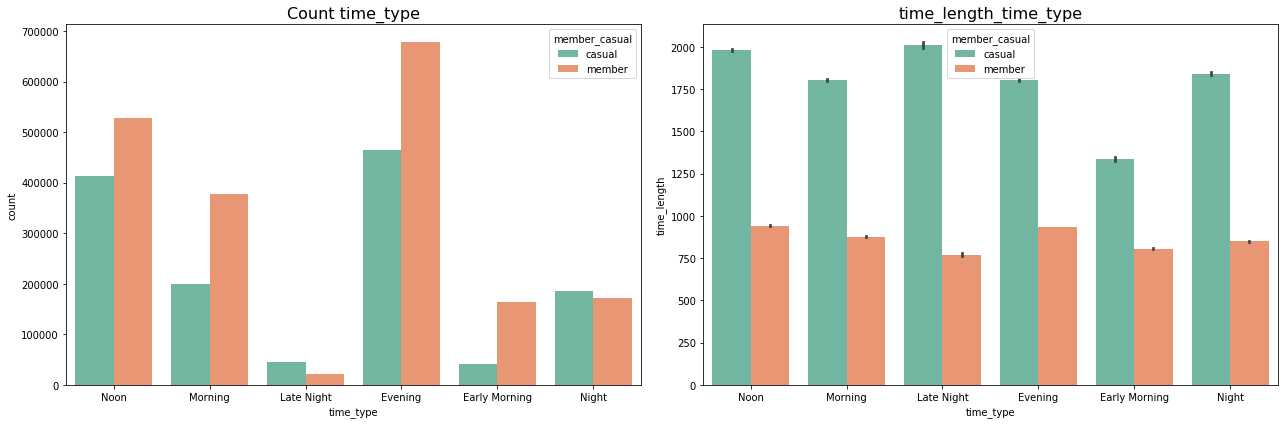

In [20]:
plot_cnt_bar(category='time_type')

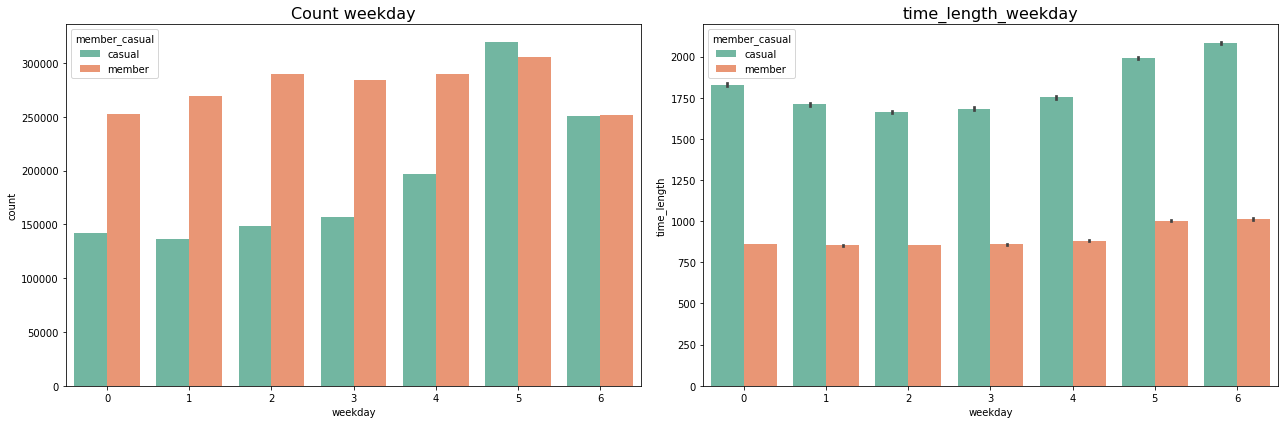

In [21]:
plot_cnt_bar(category='weekday')

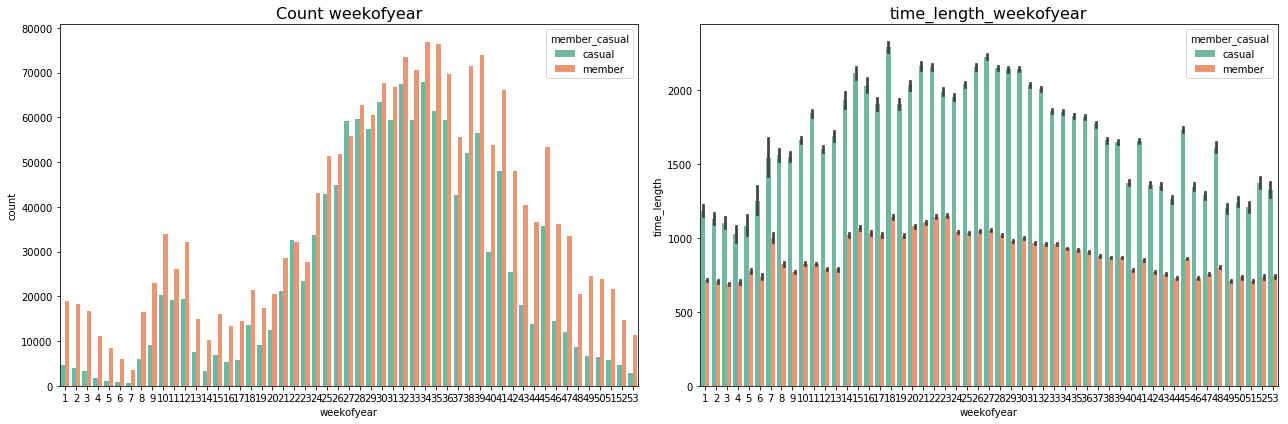

In [22]:
plot_cnt_bar(category='weekofyear')

In [23]:
### spacial info
casual_startstation_top20 = Counter(df[df['member_casual'] =='casual']['start_station_name']).most_common(20)
member_startstation_top20 = Counter(df[df['member_casual'] =='member']['start_station_name']).most_common(20)
station_lst = [i[0] for i in member_startstation_top20] + [i[0] for i in casual_startstation_top20]
station_lst = list(set(station_lst))
station_df = df[df.start_station_name.isin(station_lst)]

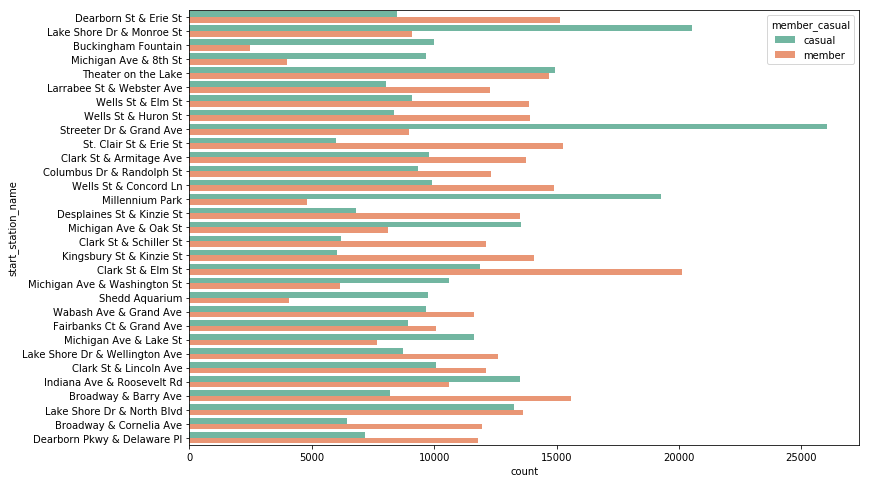

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(y='start_station_name', hue='member_casual', data=station_df)
plt.savefig('station_popularity_compare.pdf',bbox_inches='tight', pad_inches=1)
plt.show()

In [25]:
member_startstation_top20 = Counter(df[df['member_casual'] =='member']['start_station_name']).most_common(20)
member_startstation_top20

[('Clark St & Elm St', 20119),
 ('Broadway & Barry Ave', 15608),
 ('St. Clair St & Erie St', 15264),
 ('Dearborn St & Erie St', 15151),
 ('Wells St & Concord Ln', 14907),
 ('Theater on the Lake', 14694),
 ('Kingsbury St & Kinzie St', 14090),
 ('Wells St & Huron St', 13920),
 ('Wells St & Elm St', 13865),
 ('Clark St & Armitage Ave', 13765),
 ('Lake Shore Dr & North Blvd', 13620),
 ('Desplaines St & Kinzie St', 13518),
 ('Lake Shore Dr & Wellington Ave', 12614),
 ('Columbus Dr & Randolph St', 12306),
 ('Larrabee St & Webster Ave', 12261),
 ('Clark St & Schiller St', 12112),
 ('Clark St & Lincoln Ave', 12097),
 ('Broadway & Cornelia Ave', 11951),
 ('Dearborn Pkwy & Delaware Pl', 11789),
 ('Wabash Ave & Grand Ave', 11626)]

In [26]:
member_endstation_top20 = Counter(df[df['member_casual'] =='member']['end_station_name']).most_common(20)
member_endstation_top20

[('Clark St & Elm St', 20610),
 ('St. Clair St & Erie St', 16401),
 ('Broadway & Barry Ave', 15832),
 ('Dearborn St & Erie St', 15761),
 ('Wells St & Concord Ln', 15390),
 ('Theater on the Lake', 14357),
 ('Kingsbury St & Kinzie St', 14290),
 ('Lake Shore Dr & North Blvd', 13213),
 ('Wabash Ave & Roosevelt Rd', 13149),
 ('Wells St & Elm St', 13135),
 ('Wells St & Huron St', 13056),
 ('Lake Shore Dr & Wellington Ave', 12850),
 ('Larrabee St & Webster Ave', 12663),
 ('Clark St & Armitage Ave', 12605),
 ('Desplaines St & Kinzie St', 12465),
 ('Wabash Ave & Grand Ave', 12230),
 ('Dearborn Pkwy & Delaware Pl', 11873),
 ('Clark St & Lincoln Ave', 11809),
 ('Broadway & Cornelia Ave', 11784),
 ('Clark St & Drummond Pl', 11451)]

In [27]:
casual_startstation_top20 = Counter(df[df['member_casual'] =='casual']['start_station_name']).most_common(20)
casual_startstation_top20

[('Streeter Dr & Grand Ave', 26049),
 ('Lake Shore Dr & Monroe St', 20524),
 ('Millennium Park', 19283),
 ('Theater on the Lake', 14939),
 ('Michigan Ave & Oak St', 13539),
 ('Indiana Ave & Roosevelt Rd', 13522),
 ('Lake Shore Dr & North Blvd', 13248),
 ('Clark St & Elm St', 11862),
 ('Michigan Ave & Lake St', 11622),
 ('Michigan Ave & Washington St', 10595),
 ('Clark St & Lincoln Ave', 10088),
 ('Buckingham Fountain', 9980),
 ('Wells St & Concord Ln', 9919),
 ('Clark St & Armitage Ave', 9769),
 ('Shedd Aquarium', 9748),
 ('Wabash Ave & Grand Ave', 9668),
 ('Michigan Ave & 8th St', 9649),
 ('Columbus Dr & Randolph St', 9350),
 ('Wells St & Elm St', 9110),
 ('Fairbanks Ct & Grand Ave', 8949)]